In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.python.framework import ops
import math
from datetime import date
import requests
import json
import urllib

C:\Users\gandh\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def split_bbox(bbox):
    bbox[0] = round(bbox[0] - 0.25, 1)
    bbox[3] = round(bbox[3] + 0.25, 1)
    lat = bbox[2] - bbox[0]
    lon = bbox[3] - bbox[1]
    Loops = max([math.ceil(lat/4.9), math.ceil(lon/4.9)])
    bbox_list = []
    for i in range(Loops-1):
        bbox_l = [bbox[0], bbox[1], round(bbox[0]+(lat/Loops),1), round(bbox[1]+(lon/Loops),1)]
        bbox_list.append(bbox_l)
        bbox = [round(bbox[0]+(lat/Loops)+0.1,1), round(bbox[1]+(lon/Loops)+0.1,1), bbox[2], bbox[3]]
    bbox_list.append(bbox)
    return bbox_list

def create_features(features_list):
    features = ''
    for feature in range(len(features_list)):
        if feature == 0:
            features += str(features_list[feature])
        else:
            features += ',' + str(features_list[feature]) 
    return features   

def create_Dates(start, end): #MM-DD-YYYY
    start = str(start).split('-')
    start_date = ''
    for k in range(-1,len(start)-1):
        start_date += start[k]
    end = str(end).split('-')
    end_date = ''
    for l in range(-1,len(end)-1):
        end_date += end[l]
    dates = [start_date, end_date]
    date = '&startDate=' + dates[0] + '&endDate=' + dates[1]
    return date

In [4]:
today = Get_todays_Date()

California_bbox = [32.5, -124.5, 42, -114.1]
California_bbox_list = split_bbox(California_bbox)

wind_features = create_features(['PRECTOT', 'RH2M', 'PS', 'T2M', 'WS50M_RANGE', 'WD50M'])

wind_dates = create_Dates('01-01-2015', '12-31-2017')

today,California_bbox_list,wind_features,wind_dates

('07-30',
 [[32.2, -124.5, 35.5, -120.9],
  [35.6, -120.8, 38.9, -117.2],
  [39.0, -117.1, 42, -113.8]],
 'PRECTOT,RH2M,PS,T2M,WS50M_RANGE,WD50M',
 '&startDate=20150101&endDate=20171231')

In [5]:
def Download_Data(bbox_list, features, dates, user_community, temp_Average, Folder_name):
    for j in range(len(bbox_list)):
        url = 'https://power.larc.nasa.gov/cgi-bin/v1/DataAccess.py?request=execute&identifier=Regional&parameters='\
        + features + dates + \
        '&userCommunity=' + user_community + '&tempAverage=' + temp_Average + '&outputList=CSV&bbox=' +\
        str(bbox_list[j][0]) + ',' + str(bbox_list[j][1]) + ',' + str(bbox_list[j][2]) + ',' + \
        str(bbox_list[j][3]) + '&user=anonymous'
        response = requests.get(url)
        csv_url = response.json()['outputs']['csv']
        urllib.request.urlretrieve(csv_url, 'Data/' + Folder_name + '/File_' + str(j+1) + '.csv')
        print('set ' + str(j+1) + ' is complete' )
    

In [6]:
Download_Data(California_bbox_list, wind_features, wind_dates, 'SB', 'DAILY', 'Wind')

set 1 is complete
set 2 is complete
set 3 is complete


In [7]:
def read_csv_file(filepath, sep=', ', delimiter=',', header='infer'):
    return pd.read_csv(filepath, sep=sep, delimiter=delimiter, header=header)

def Check(df):
    print('shape:' ,df.shape)
    return df.head()

def Get_csv(bbox_list, Folder_name, header):
    data = []
    for k in range(len(bbox_list)):
        data.append(read_csv_file('Data/' + Folder_name + '/File_' + str(k+1) + '.csv', header=header))
    df = pd.concat(data).reset_index(drop=True)
    try:
        df = df.sort_values(['DY', 'MO', 'YEAR','LAT', 'LON'], axis=0).reset_index(drop=True)
    except:
        df = df.sort_values(['LAT', 'LON'], axis=0).reset_index(drop=True)
    df = df.drop_duplicates().reset_index(drop=True)
    return df

wind_data = Get_csv(California_bbox_list, 'Wind', 15)

wind_data['LON'] = wind_data.LON.apply(lambda x:-x)

Check(wind_data)
# wind_data.tail()

shape: (191800, 11)


,LAT,LON,YEAR,MO,DY,PRECTOT,RH2M,PS,T2M,WS50M_RANGE,WD50M
0,32.25,124.25,2015,1,1,0.02,72.23,102.08,15.17,4.29,328.89
1,32.25,123.75,2015,1,1,0.01,71.51,102.07,14.91,3.94,326.24
2,32.25,123.25,2015,1,1,0.00,70.56,102.05,14.72,3.87,324.77
3,32.25,122.75,2015,1,1,0.00,69.12,102.04,14.56,3.73,324.04
4,32.25,122.25,2015,1,1,0.00,67.54,102.03,14.49,3.66,322.67


In [8]:
wind_data.dtypes

LAT            float64
LON            float64
YEAR             int64
MO               int64
DY               int64
PRECTOT        float64
RH2M           float64
PS             float64
T2M            float64
WS50M_RANGE    float64
WD50M          float64
dtype: object

In [9]:
def Replace_witn_nan(df, null_denoter):
    df = df.replace(to_replace=null_denoter, value=np.nan)
    return df

def Check_NAN(df):
    return df.isnull().sum()

Replace_witn_nan(wind_data, -999.0 or 'nan' or "NAN" or 'NA')

Check_NAN(wind_data)

LAT            0
LON            0
YEAR           0
MO             0
DY             0
PRECTOT        0
RH2M           0
PS             0
T2M            0
WS50M_RANGE    0
WD50M          0
dtype: int64

In [10]:
def Add_Date_Column(df):
    Date = pd.DataFrame({'year': df['YEAR'],
                       'month': df['MO'],
                       'day': df['DY']})
    Date = pd.to_datetime(Date)
    df['DATE'] = Date
    return df

wind_data = Add_Date_Column(wind_data)

Check(wind_data)

shape: (191800, 12)


,LAT,LON,YEAR,MO,DY,PRECTOT,RH2M,PS,T2M,WS50M_RANGE,WD50M,DATE
0,32.25,124.25,2015,1,1,0.02,72.23,102.08,15.17,4.29,328.89,2015-01-01
1,32.25,123.75,2015,1,1,0.01,71.51,102.07,14.91,3.94,326.24,2015-01-01
2,32.25,123.25,2015,1,1,0.00,70.56,102.05,14.72,3.87,324.77,2015-01-01
3,32.25,122.75,2015,1,1,0.00,69.12,102.04,14.56,3.73,324.04,2015-01-01
4,32.25,122.25,2015,1,1,0.00,67.54,102.03,14.49,3.66,322.67,2015-01-01


In [11]:
degree_celcius =  u"\u2103"
degree = u'\xb0'
square = '\u00b2'

In [12]:
wind_data.columns = ['Latitude (' + degree + 'N)', 'Longitude (' + degree + 'W)', 'Year', 'Month', 'Day', 'Precepitation (mm/day)', \
                'Relative Humidity at 2m (%)', 'Surface Pressure (kPa)', \
                'Temperature at 2m (' + str(degree_celcius) + ')','Wind Speed at 50m (m/s)', \
                'Wind Direction at 50m (' + degree + ')', 'Date']

In [13]:
def Drop_Column(df,column):
    df = df.drop(column, axis=1)
    return df

wind_data = Drop_Column(wind_data, ['Year', 'Month', 'Day'])

Check(wind_data)

shape: (191800, 9)


,Latitude (°N),Longitude (°W),Precepitation (mm/day),Relative Humidity at 2m (%),Surface Pressure (kPa),Temperature at 2m (℃),Wind Speed at 50m (m/s),Wind Direction at 50m (°),Date
0,32.25,124.25,0.02,72.23,102.08,15.17,4.29,328.89,2015-01-01
1,32.25,123.75,0.01,71.51,102.07,14.91,3.94,326.24,2015-01-01
2,32.25,123.25,0.00,70.56,102.05,14.72,3.87,324.77,2015-01-01
3,32.25,122.75,0.00,69.12,102.04,14.56,3.73,324.04,2015-01-01
4,32.25,122.25,0.00,67.54,102.03,14.49,3.66,322.67,2015-01-01


In [14]:
All_lat = list(wind_data['Latitude (' + degree + 'N)'].unique())
All_lon = list(wind_data['Longitude (' + degree + 'W)'].unique())
Combination =  list(itertools.product(All_lat, All_lon))

In [15]:
def Save_as_CSV(df, Folder_name, File_name):
    df.to_csv('Data/' + Folder_name + '/' + File_name + '.csv', index=False)

Save_as_CSV(wind_data, 'Wind', '2015 to 2017')

In [16]:
solar_features = create_features(['PRECTOT', 'RH2M', 'PS', 'T2M', 'ALLSKY_SFC_LW_DWN', 'KT_CLEAR', 'CLRSKY_SFC_SW_DWN', 'ALLSKY_TOA_SW_DWN', 'ALLSKY_SFC_SW_DWN'])
solar_dates = create_Dates('01-01-2015', '12-31-2017')

In [17]:
Download_Data(California_bbox_list, solar_features, solar_dates, 'SB', 'DAILY', 'Solar')

set 1 is complete
set 2 is complete
set 3 is complete


In [18]:
solar_data = Get_csv(California_bbox_list, 'Solar', 18)

solar_data['LON'] = solar_data.LON.apply(lambda x:-x)

solar_data = Add_Date_Column(solar_data)

Check(solar_data)

C:\Users\sngandhi\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2963: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


shape: (191872, 15)


,LAT,LON,YEAR,MO,DY,PRECTOT,RH2M,PS,T2M,ALLSKY_SFC_LW_DWN,KT_CLEAR,CLRSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,DATE
0,32.25,124.25,2015,1,1,0.02,72.23,102.08,15.17,8.28,0.40,-999.0,5.16,2.04,2015-01-01
1,32.25,123.75,2015,1,1,0.01,71.51,102.07,14.91,7.90,0.50,-999.0,5.10,2.55,2015-01-01
2,32.25,123.25,2015,1,1,0.00,70.56,102.05,14.72,7.90,0.50,-999.0,5.10,2.55,2015-01-01
3,32.25,122.75,2015,1,1,0.00,69.12,102.04,14.56,7.45,0.53,-999.0,5.15,2.71,2015-01-01
4,32.25,122.25,2015,1,1,0.00,67.54,102.03,14.49,7.45,0.53,-999.0,5.15,2.71,2015-01-01


In [19]:
solar_data.dtypes

LAT                         float64
LON                         float64
YEAR                          int64
MO                            int64
DY                            int64
PRECTOT                     float64
RH2M                        float64
PS                          float64
T2M                         float64
ALLSKY_SFC_LW_DWN           float64
KT_CLEAR                     object
CLRSKY_SFC_SW_DWN           float64
ALLSKY_TOA_SW_DWN           float64
ALLSKY_SFC_SW_DWN           float64
DATE                 datetime64[ns]
dtype: object

In [20]:
solar_data['KT_CLEAR'] = solar_data['KT_CLEAR'].astype('float64')

solar_data = Replace_witn_nan(solar_data, -999.0 or 'nan' or "NAN" or 'NA')

Check_NAN(solar_data)

LAT                       0
LON                       0
YEAR                      0
MO                        0
DY                        0
PRECTOT                 175
RH2M                      0
PS                        0
T2M                       0
ALLSKY_SFC_LW_DWN         2
KT_CLEAR                303
CLRSKY_SFC_SW_DWN    107679
ALLSKY_TOA_SW_DWN       265
ALLSKY_SFC_SW_DWN       128
DATE                      0
dtype: int64

In [21]:
# More than half of values CLRSKY_SFC_SW_DWN column are null. Thus this column needs to be dropped

solar_data = Drop_Column(solar_data,['CLRSKY_SFC_SW_DWN'])

In [22]:
def Fill_Null_vals(df):
    try:
        df = df.fillna(method='ffill')
    except:
        df = df.fillna(method='bfill')
    return(df)

solar_data = Fill_Null_vals(solar_data)

Check_NAN(solar_data)

LAT                  0
LON                  0
YEAR                 0
MO                   0
DY                   0
PRECTOT              0
RH2M                 0
PS                   0
T2M                  0
ALLSKY_SFC_LW_DWN    0
KT_CLEAR             0
ALLSKY_TOA_SW_DWN    0
ALLSKY_SFC_SW_DWN    0
DATE                 0
dtype: int64

In [23]:
solar_data.columns = ['Latitude (' + degree + 'N)', 'Longitude (' + degree + 'W)', 'Year', 'Month', 'Day', 'Precepitation (mm/day)', \
                    'Relative Humidity at 2m (%)', 'Surface Pressure (kPa)', \
                    'Temperature at 2m (' + str(degree_celcius) + ')', \
                    'Downward Thermal Infrared Radiative Flux (kW-hr/m' + square + '/day)',\
                    'Clear Sky Insolation Clearness Index',\
                    'Top of Atmosphere Insolation (kW-hr/m' + square + '/day)', \
                    'All Sky Insolation (kW-hr/m' + square + '/day)', 'Date']

solar_data = Drop_Column(solar_data, ['Year', 'Month', 'Day'])

Check(solar_data)

shape: (191872, 11)


,Latitude (°N),Longitude (°W),Precepitation (mm/day),Relative Humidity at 2m (%),Surface Pressure (kPa),Temperature at 2m (℃),Downward Thermal Infrared Radiative Flux (kW-hr/m²/day),Clear Sky Insolation Clearness Index,Top of Atmosphere Insolation (kW-hr/m²/day),All Sky Insolation (kW-hr/m²/day),Date
0,32.25,124.25,0.02,72.23,102.08,15.17,8.28,0.40,5.16,2.04,2015-01-01
1,32.25,123.75,0.01,71.51,102.07,14.91,7.90,0.50,5.10,2.55,2015-01-01
2,32.25,123.25,0.00,70.56,102.05,14.72,7.90,0.50,5.10,2.55,2015-01-01
3,32.25,122.75,0.00,69.12,102.04,14.56,7.45,0.53,5.15,2.71,2015-01-01
4,32.25,122.25,0.00,67.54,102.03,14.49,7.45,0.53,5.15,2.71,2015-01-01


In [24]:
solar_data = solar_data.drop_duplicates()

Check(solar_data)

shape: (191800, 11)


,Latitude (°N),Longitude (°W),Precepitation (mm/day),Relative Humidity at 2m (%),Surface Pressure (kPa),Temperature at 2m (℃),Downward Thermal Infrared Radiative Flux (kW-hr/m²/day),Clear Sky Insolation Clearness Index,Top of Atmosphere Insolation (kW-hr/m²/day),All Sky Insolation (kW-hr/m²/day),Date
0,32.25,124.25,0.02,72.23,102.08,15.17,8.28,0.40,5.16,2.04,2015-01-01
1,32.25,123.75,0.01,71.51,102.07,14.91,7.90,0.50,5.10,2.55,2015-01-01
2,32.25,123.25,0.00,70.56,102.05,14.72,7.90,0.50,5.10,2.55,2015-01-01
3,32.25,122.75,0.00,69.12,102.04,14.56,7.45,0.53,5.15,2.71,2015-01-01
4,32.25,122.25,0.00,67.54,102.03,14.49,7.45,0.53,5.15,2.71,2015-01-01


In [25]:
Save_as_CSV(solar_data, 'Solar', '2015 to 2017')

In [26]:
DNR_features = create_features(['RH2M', 'PS', 'T2M', 'ALLSKY_SFC_LW_DWN', 'KT_CLEAR', 'CLRSKY_SFC_SW_DWN', 'ALLSKY_TOA_SW_DWN', 'ALLSKY_SFC_SW_DWN', 'DNR'])

Download_Data(California_bbox_list, DNR_features, '', 'SB', 'CLIMATOLOGY', 'DNR')

set 1 is complete
set 2 is complete
set 3 is complete


In [27]:
solar_monthly = Get_csv(California_bbox_list, 'DNR', 19)

solar_monthly['LON'] = solar_monthly.LON.apply(lambda x:-x)

Check(solar_monthly)

shape: (1575, 16)


,LAT,LON,PARAMETER,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN
0,32.25,124.25,RH2M,83.32,82.71,83.35,83.22,85.43,87.28,88.38,87.72,85.74,84.61,82.15,80.77,84.56
1,32.25,124.25,PS,102.13,102.01,102.04,102.01,101.90,101.75,101.72,101.69,101.61,101.78,102.02,102.11,101.90
2,32.25,124.25,T2M,14.33,13.92,13.84,14.04,14.93,15.84,16.88,17.76,17.97,17.52,16.41,15.07,15.71
3,32.25,124.25,ALLSKY_SFC_LW_DWN,8.06,8.09,8.03,7.99,8.21,8.46,8.78,8.73,8.62,8.45,8.24,8.10,8.31
4,32.25,124.25,KT_CLEAR,0.55,0.55,0.58,0.60,0.59,0.55,0.49,0.52,0.55,0.57,0.56,0.54,0.55


In [28]:
# Rearranging solar_monthly data

Features = list(solar_monthly.PARAMETER.unique())
Months = list(solar_monthly.columns[3:15])

solar_monthly_con = pd.DataFrame()
for feature in Features:
    solar_monthly_f  = solar_monthly[solar_monthly['PARAMETER']==feature].reset_index(drop=True)
    solar_monthly_m_con = pd.DataFrame()
    for month in Months:
        solar_monthly_f_m  = solar_monthly_f[['LAT','LON',month]]
        solar_monthly_f_m.columns = ['LAT','LON',feature]
        m = Months.index(month)
        solar_monthly_f_m['MONTH'] = [m+1]*len(solar_monthly_f_m)
        solar_monthly_m_con = pd.concat([solar_monthly_m_con, solar_monthly_f_m]).reset_index(drop=True)
    solar_monthly_con = pd.concat([solar_monthly_con, solar_monthly_m_con], ignore_index = False, axis=1)
solar_monthly_con = solar_monthly_con.T.drop_duplicates().T

Check(solar_monthly_con)

C:\Users\sngandhi\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


shape: (2100, 12)


,LAT,LON,RH2M,MONTH,PS,T2M,ALLSKY_SFC_LW_DWN,KT_CLEAR,CLRSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,DNR
0,32.25,124.25,83.32,1.0,102.13,14.33,8.06,0.55,3.98,5.54,3.02,4.77
1,32.25,123.75,83.62,1.0,102.11,14.21,8.00,0.56,3.98,5.54,3.06,4.89
2,32.25,123.25,83.87,1.0,102.10,14.12,8.00,0.56,3.98,5.54,3.06,4.89
3,32.25,122.75,84.03,1.0,102.07,14.06,7.94,0.57,3.99,5.54,3.12,5.07
4,32.25,122.25,84.20,1.0,102.05,14.02,7.94,0.57,3.99,5.54,3.12,5.07


In [29]:
solar_monthly_con.dtypes

LAT                  float64
LON                  float64
RH2M                 float64
MONTH                float64
PS                   float64
T2M                  float64
ALLSKY_SFC_LW_DWN    float64
KT_CLEAR             float64
CLRSKY_SFC_SW_DWN    float64
ALLSKY_TOA_SW_DWN    float64
ALLSKY_SFC_SW_DWN    float64
DNR                  float64
dtype: object

In [30]:
Replace_witn_nan(solar_monthly_con, -999.0 or 'nan' or "NAN" or 'NA')

Check_NAN(solar_monthly_con)

LAT                  0
LON                  0
RH2M                 0
MONTH                0
PS                   0
T2M                  0
ALLSKY_SFC_LW_DWN    0
KT_CLEAR             0
CLRSKY_SFC_SW_DWN    0
ALLSKY_TOA_SW_DWN    0
ALLSKY_SFC_SW_DWN    0
DNR                  0
dtype: int64

In [31]:
solar_monthly_con = Drop_Column(solar_monthly_con, 'CLRSKY_SFC_SW_DWN')

Check(solar_monthly_con)

shape: (2100, 11)


,LAT,LON,RH2M,MONTH,PS,T2M,ALLSKY_SFC_LW_DWN,KT_CLEAR,ALLSKY_TOA_SW_DWN,ALLSKY_SFC_SW_DWN,DNR
0,32.25,124.25,83.32,1.0,102.13,14.33,8.06,0.55,5.54,3.02,4.77
1,32.25,123.75,83.62,1.0,102.11,14.21,8.00,0.56,5.54,3.06,4.89
2,32.25,123.25,83.87,1.0,102.10,14.12,8.00,0.56,5.54,3.06,4.89
3,32.25,122.75,84.03,1.0,102.07,14.06,7.94,0.57,5.54,3.12,5.07
4,32.25,122.25,84.20,1.0,102.05,14.02,7.94,0.57,5.54,3.12,5.07


In [32]:
solar_monthly_con.columns = ['Latitude (' + degree + 'N)', 'Longitude (' + degree + 'W)', 'Relative Humidity at 2m (%)', 'MONTH', 'Surface Pressure (kPa)','Temperature at 2m (' + str(degree_celcius) + ')',\
                             'Downward Thermal Infrared Radiative Flux (kW-hr/m' + square + '/day)',\
                             'Clear Sky Insolation Clearness Index', \
                             'Top of Atmosphere Insolation (kW-hr/m' + square + '/day)', \
                              'All Sky Insolation (kW-hr/m' + square + '/day)', \
                              'Direct Normal Radiation (kW-hr/m' + square + '/day)']



In [33]:
# Creating One Hot Vectors for Months

for month in Months:
    m = Months.index(month)
    solar_monthly_con[month] = [0]*len(solar_monthly_con)
    solar_monthly_con.loc[solar_monthly_con['MONTH'] == m+1, month] = 1

solar_monthly_con = Drop_Column(solar_monthly_con,'MONTH')

Check(solar_monthly_con)

shape: (2100, 22)


,Latitude (°N),Longitude (°W),Relative Humidity at 2m (%),Surface Pressure (kPa),Temperature at 2m (℃),Downward Thermal Infrared Radiative Flux (kW-hr/m²/day),Clear Sky Insolation Clearness Index,Top of Atmosphere Insolation (kW-hr/m²/day),All Sky Insolation (kW-hr/m²/day),Direct Normal Radiation (kW-hr/m²/day),...,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,32.25,124.25,83.32,102.13,14.33,8.06,0.55,5.54,3.02,4.77,...,0,0,0,0,0,0,0,0,0,0
1,32.25,123.75,83.62,102.11,14.21,8.00,0.56,5.54,3.06,4.89,...,0,0,0,0,0,0,0,0,0,0
2,32.25,123.25,83.87,102.10,14.12,8.00,0.56,5.54,3.06,4.89,...,0,0,0,0,0,0,0,0,0,0
3,32.25,122.75,84.03,102.07,14.06,7.94,0.57,5.54,3.12,5.07,...,0,0,0,0,0,0,0,0,0,0
4,32.25,122.25,84.20,102.05,14.02,7.94,0.57,5.54,3.12,5.07,...,0,0,0,0,0,0,0,0,0,0


In [34]:
Save_as_CSV(solar_monthly_con, 'DNR', 'DNR with Features')

In [35]:
# Train-Validate-Test Split

def X_y_split(df,n):# n = index of column of y
    cols = list(df.columns)
    del(cols[n])
    X = df.loc[:,cols]
    Y = df.iloc[:,n]
    return X,Y

def Series_to_Dataframe(Series):
    return Series.to_frame()

def train_validate_test_split(df, n, train_percent=.7, validate_percent=.2, seed=True):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    train_x, train_y = X_y_split(train,n)
    validate = df.iloc[perm[train_end:validate_end]]
    val_x, val_y = X_y_split(validate,n)
    test = df.iloc[perm[validate_end:]]
    test_x, test_y = X_y_split(test,n)
    train_y = Series_to_Dataframe(train_y)
    val_y = Series_to_Dataframe(val_y)
    test_y = Series_to_Dataframe(test_y)
    return train_x, val_x, test_x, train_y, val_y, test_y

train_x, val_x, test_x, train_y, val_y, test_y = train_validate_test_split(solar_monthly_con, 9, train_percent=.7, validate_percent=.2, seed=True)

names = ['train_x', 'val_x', 'test_x', 'train_y', 'val_y', 'test_y']
files = [train_x, val_x, test_x, train_y, val_y, test_y]

In [36]:
# min_max_scaler = preprocessing.MinMaxScaler()
def Normalize(df):
    list_of_cols = list(df.columns)
    x = df[list_of_cols].values.astype(float)
    x_scaled = x / (x.max(axis=0) + np.spacing(0))
    x_max = x.max(axis=0)
    df_normalized = pd.DataFrame(x_scaled)
    df_max = pd.DataFrame(x_max).T
    df_normalized.columns = list_of_cols
    df_max.columns = list_of_cols
    return df_normalized, df_max

Normalized_files = []
Cols_max=[]
for file in files:
    Normalized_file = Normalize(file)[0]
    file_max = Normalize(file)[1]
    Normalized_files.append(Normalized_file)
    Cols_max.append(file_max)
    
for i in range(len(Normalized_files)):
    print(names[i]+ ': ', Normalized_files[i].shape)

train_x:  (1470, 21)
val_x:  (420, 21)
test_x:  (210, 21)
train_y:  (1470, 1)
val_y:  (420, 1)
test_y:  (210, 1)


In [37]:
# Saving Files as .txt

for i in range(6):
    print(names[i])
    Check(Normalized_files[i])
    np.savetxt('Data/Neural Network/Normalized Files/solar_monthly_con_' + names[i] + '.txt', Normalized_files[i].values)
    np.savetxt('Data/Neural Network/Maximum Values/solar_monthly_con_' + names[i] + '_max_values.txt', Cols_max[i].values)

train_x
shape: (1470, 21)
val_x
shape: (420, 21)
test_x
shape: (210, 21)
train_y
shape: (1470, 1)
val_y
shape: (420, 1)
test_y
shape: (210, 1)


In [38]:
# Loading Processed txt files

names = ['train_x', 'val_x', 'test_x', 'train_y', 'val_y', 'test_y']
solar_monthly_arr = []
for name in names:
    txt_file = np.loadtxt('Data/Neural Network/Normalized files/solar_monthly_con_' + name + '.txt', dtype=float)
    solar_monthly_arr.append(txt_file)

In [39]:
def replace_zeros(arr):
    np.place(arr, arr==0, 1e-10)
    return arr

X_train = replace_zeros(solar_monthly_arr[0])
X_val = replace_zeros(solar_monthly_arr[1])
X_test = replace_zeros(solar_monthly_arr[2])
y_train = replace_zeros(solar_monthly_arr[3])
y_val = replace_zeros(solar_monthly_arr[4])
y_test = replace_zeros(solar_monthly_arr[5])

In [40]:
X_train = X_train.T
X_val = X_val.T

y_train=y_train[np.newaxis]
y_val=y_val[np.newaxis]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((21, 1470), (21, 420), (1, 1470), (1, 420))

In [41]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(shape=[n_x, None], dtype=tf.float32)
    Y = tf.placeholder(shape=[n_y, None], dtype=tf.float32)
    return X, Y

X, Y = create_placeholders(768, 3)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(768, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(3, ?), dtype=float32)


In [42]:
def initialize_parameters(n_x, n_y, layers=4, layers_dim=[64, 64, 64, 1]):
    
    tf.set_random_seed(1)
    parameters={}
    for l in range(layers):
        if l == 0:
            parameters["W"+str(l+1)] = tf.get_variable("W"+str(l+1), [layers_dim[l], n_x], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
            parameters["b"+str(l+1)] = tf.get_variable("b"+str(l+1), [layers_dim[l], 1], initializer=tf.zeros_initializer())
        else:
            parameters["W"+str(l+1)] = tf.get_variable("W"+str(l+1), [layers_dim[l], layers_dim[l-1]], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
            parameters["b"+str(l+1)] = tf.get_variable("b"+str(l+1), [layers_dim[l], 1], initializer=tf.zeros_initializer())
    
    return parameters
#     W1 = tf.get_variable("W1", [25,12288], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
#     b1 = tf.get_variable("b1", [25, 1], initializer=tf.zeros_initializer())
#     W2 = tf.get_variable("W2", [12, 25], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
#     b2 = tf.get_variable("b2", [12, 1], initializer=tf.zeros_initializer())
#     W3 = tf.get_variable("W3", [6, 12], initializer=tf.contrib.layers.xavier_initializer(seed = 1))
#     b3 = tf.get_variable("b3", [6, 1], initializer=tf.zeros_initializer())

In [43]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters(768, 3)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print("W3 = " + str(parameters["W3"]))
    print("b3 = " + str(parameters["b3"]))
    print("W4 = " + str(parameters["W4"]))
    print("b4 = " + str(parameters["b4"]))

W1 = <tf.Variable 'W1:0' shape=(64, 768) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(64, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(64, 64) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(64, 1) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(64, 64) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(64, 1) dtype=float32_ref>
W4 = <tf.Variable 'W4:0' shape=(1, 64) dtype=float32_ref>
b4 = <tf.Variable 'b4:0' shape=(1, 1) dtype=float32_ref>


In [44]:
def forward_propagation(X, parameters, activation_types=["relu","relu","relu","relu"]):
    mul = {}
    L = int(len(parameters)/2)
    for l in range(L):
        if l == 0:
            mul["Z"+str(l+1)] = parameters["W"+str(l+1)] @ X + parameters["b"+str(l+1)]
        else:
            mul["Z"+str(l+1)] = parameters["W"+str(l+1)] @ mul["A"+str(l)] + parameters["b"+str(l+1)]
        if activation_types[l] == "relu":
            mul["A"+str(l+1)] = tf.nn.relu(mul["Z"+str(l+1)])
        elif activation_types[l] == "sigmoid":
            mul["A"+str(l+1)] = tf.nn.sigmoid(mul["Z"+str(l+1)])
        else:
            mul["A"+str(l+1)] = mul["Z"+str(l+1)]
        
    return mul["A"+str(int(len(parameters)/2))]
    

In [45]:
def compute_cost(AL, Y, cost_type="mse"):
#     m = Y.shape[0]
    cost = tf.reduce_mean((AL-Y)**2)
    return cost

In [46]:
def random_minibatches(X, Y, mini_batch_size=8, seed=1):
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k*mini_batch_size: (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size: (k+1)*mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

Cost after epoch 0: 0.007743


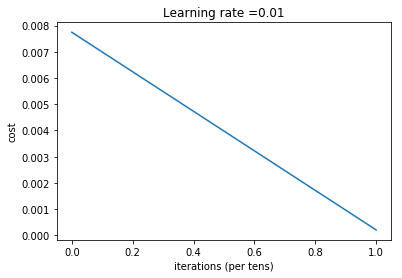

Train accuracy:  -0.0021532136
Test accuracy:  -0.0036896504


In [47]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.01, num_epochs=100, print_cost=True, mini_batch_size=8):
    ops.reset_default_graph()
#     tf.set_random_seed(1)
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs=[]
    
    X, Y = create_placeholders(n_x, n_y)
    
    parameters = initialize_parameters(n_x, n_y)
    
    AL = forward_propagation(X, parameters)
    
    cost = compute_cost(AL, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = m/mini_batch_size
            minibatches = random_minibatches(X_train, Y_train)
            for minibatch in minibatches:
                minibatch_X, minibatch_Y = minibatch
                _, minibatch_cost = sess.run((optimizer, cost), feed_dict={X:minibatch_X, Y:minibatch_Y})
                epoch_cost += minibatch_cost/num_minibatches
                
            if print_cost == True:
                if epoch%50==0:
                    costs.append(epoch_cost)
                    if epoch%100==0:
                        print("Cost after epoch %i: %f" % (epoch, epoch_cost))
                        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        accuracy = tf.reduce_mean(1-AL/Y)

        print("Train accuracy: ", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test accuracy: ", accuracy.eval({X: X_test, Y: Y_test}))
    
    return parameters

parameters = model(X_train, y_train, X_val, y_val)

In [48]:
X_test = X_test.T
y_test=y_test.reshape(1, -1)

with tf.Session() as sess:
    X, Y = create_placeholders(21, 1)
    AL = forward_propagation(X, parameters)
    accuracy = tf.reduce_mean(tf.abs(1-AL/Y))
    print("Train accuracy: ", (1-accuracy.eval({X: X_train, Y: y_train}))*100,"%")
    print("Validation accuracy: ", (1-accuracy.eval({X: X_val, Y: y_val}))*100,"%")
    print("Test accuracy: ", (1-accuracy.eval({X: X_test, Y: y_test}))*100,"%")

Train accuracy:  98.97187827154994 %
Validation accuracy:  98.87978304177523 %
Test accuracy:  98.4348637983203 %


In [49]:
solar_data_2 = solar_data

solar_data_2['Month'] = solar_data_2['Date'].dt.month

solar_data_2 = Drop_Column(solar_data_2, ['Date', 'Precepitation (mm/day)'])

solar_data_2['Downward Thermal Infrared Radiative Flux (kW-hr/m' + square + '/day)'] = solar_data_2.iloc[:,2].astype('float64')
solar_data_2['Month'] = solar_data_2['Month'].astype('float64')

Check(solar_data_2)

shape: (191800, 10)


,Latitude (°N),Longitude (°W),Relative Humidity at 2m (%),Surface Pressure (kPa),Temperature at 2m (℃),Downward Thermal Infrared Radiative Flux (kW-hr/m²/day),Clear Sky Insolation Clearness Index,Top of Atmosphere Insolation (kW-hr/m²/day),All Sky Insolation (kW-hr/m²/day),Month
0,32.25,124.25,72.23,102.08,15.17,72.23,0.40,5.16,2.04,1.0
1,32.25,123.75,71.51,102.07,14.91,71.51,0.50,5.10,2.55,1.0
2,32.25,123.25,70.56,102.05,14.72,70.56,0.50,5.10,2.55,1.0
3,32.25,122.75,69.12,102.04,14.56,69.12,0.53,5.15,2.71,1.0
4,32.25,122.25,67.54,102.03,14.49,67.54,0.53,5.15,2.71,1.0


In [50]:
for month in Months:
    m = Months.index(month)
    solar_data_2[month] = [0]*len(solar_data_2)
    solar_data_2.loc[solar_data_2['Month'] == m+1, month] = 1

solar_data_2 = Drop_Column(solar_data_2,'Month')

Check(solar_data_2)

shape: (191800, 21)


,Latitude (°N),Longitude (°W),Relative Humidity at 2m (%),Surface Pressure (kPa),Temperature at 2m (℃),Downward Thermal Infrared Radiative Flux (kW-hr/m²/day),Clear Sky Insolation Clearness Index,Top of Atmosphere Insolation (kW-hr/m²/day),All Sky Insolation (kW-hr/m²/day),JAN,...,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,32.25,124.25,72.23,102.08,15.17,72.23,0.40,5.16,2.04,1,...,0,0,0,0,0,0,0,0,0,0
1,32.25,123.75,71.51,102.07,14.91,71.51,0.50,5.10,2.55,1,...,0,0,0,0,0,0,0,0,0,0
2,32.25,123.25,70.56,102.05,14.72,70.56,0.50,5.10,2.55,1,...,0,0,0,0,0,0,0,0,0,0
3,32.25,122.75,69.12,102.04,14.56,69.12,0.53,5.15,2.71,1,...,0,0,0,0,0,0,0,0,0,0
4,32.25,122.25,67.54,102.03,14.49,67.54,0.53,5.15,2.71,1,...,0,0,0,0,0,0,0,0,0,0


In [51]:
solar_data_norm = Normalize(solar_data_2)
solar_data_norm[1]

,Latitude (°N),Longitude (°W),Relative Humidity at 2m (%),Surface Pressure (kPa),Temperature at 2m (℃),Downward Thermal Infrared Radiative Flux (kW-hr/m²/day),Clear Sky Insolation Clearness Index,Top of Atmosphere Insolation (kW-hr/m²/day),All Sky Insolation (kW-hr/m²/day),JAN,...,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,42.25,124.25,100.0,103.37,36.74,100.0,0.82,12.26,9.34,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [52]:
np.savetxt('Data/Neural Network/Normalized files/solar_data.txt', solar_data_norm[0].values)
np.savetxt('Data/Neural Network/Maximum Values/solar_data_max_values.txt', solar_data_norm[1].values)

In [53]:
Predict_X = np.loadtxt('Data/Neural Network/Normalized files/solar_data.txt', dtype=float)

In [54]:
Predict_X = replace_zeros(Predict_X)
Predict_X.shape

(191800, 21)

In [55]:
Predict_X = Predict_X.T
with tf.Session() as sess:
    X, Y = create_placeholders(17, 1)
    pred = forward_propagation(Predict_X, parameters)
    DNR_array = pred.eval()

In [56]:
DNR_array = DNR_array.T
DNR_max = np.loadtxt('Data/Neural Network/Maximum Values/solar_monthly_con_train_y_max_values.txt', dtype=float)
DNR_array = DNR_array*DNR_max
DNR_array

array([[3.41354497],
       [3.4301036 ],
       [3.42017811],
       ...,
       [5.02758902],
       [4.99782251],
       [5.70307907]])

In [57]:
Check(solar_data)

shape: (191800, 12)


,Latitude (°N),Longitude (°W),Precepitation (mm/day),Relative Humidity at 2m (%),Surface Pressure (kPa),Temperature at 2m (℃),Downward Thermal Infrared Radiative Flux (kW-hr/m²/day),Clear Sky Insolation Clearness Index,Top of Atmosphere Insolation (kW-hr/m²/day),All Sky Insolation (kW-hr/m²/day),Date,Month
0,32.25,124.25,0.02,72.23,102.08,15.17,8.28,0.40,5.16,2.04,2015-01-01,1
1,32.25,123.75,0.01,71.51,102.07,14.91,7.90,0.50,5.10,2.55,2015-01-01,1
2,32.25,123.25,0.00,70.56,102.05,14.72,7.90,0.50,5.10,2.55,2015-01-01,1
3,32.25,122.75,0.00,69.12,102.04,14.56,7.45,0.53,5.15,2.71,2015-01-01,1
4,32.25,122.25,0.00,67.54,102.03,14.49,7.45,0.53,5.15,2.71,2015-01-01,1


In [58]:
solar_data = Drop_Column(solar_data, 'Month')
solar_data['Direct Normal Radiation (kW-hr/m' + square + '/day)'] = DNR_array

In [59]:
Check(solar_data)

shape: (191800, 12)


,Latitude (°N),Longitude (°W),Precepitation (mm/day),Relative Humidity at 2m (%),Surface Pressure (kPa),Temperature at 2m (℃),Downward Thermal Infrared Radiative Flux (kW-hr/m²/day),Clear Sky Insolation Clearness Index,Top of Atmosphere Insolation (kW-hr/m²/day),All Sky Insolation (kW-hr/m²/day),Date,Direct Normal Radiation (kW-hr/m²/day)
0,32.25,124.25,0.02,72.23,102.08,15.17,8.28,0.40,5.16,2.04,2015-01-01,3.413545
1,32.25,123.75,0.01,71.51,102.07,14.91,7.90,0.50,5.10,2.55,2015-01-01,3.430104
2,32.25,123.25,0.00,70.56,102.05,14.72,7.90,0.50,5.10,2.55,2015-01-01,3.420178
3,32.25,122.75,0.00,69.12,102.04,14.56,7.45,0.53,5.15,2.71,2015-01-01,3.807574
4,32.25,122.25,0.00,67.54,102.03,14.49,7.45,0.53,5.15,2.71,2015-01-01,3.836880


In [60]:
Save_as_CSV(solar_data, 'Solar', '2015 to 2017 with DNR')

In [67]:
solar_data_2['Direct Normal Radiation (kW-hr/m' + square + '/day)'] = DNR_array

Save_as_CSV(solar_data_2, 'Neural Network', '2015 to 2017 Solar with all Features')

In [61]:
solar_data.shape, wind_data.shape

((191800, 12), (191800, 9))

In [62]:
data = solar_data.merge(wind_data)

Check(data)

shape: (191625, 14)


,Latitude (°N),Longitude (°W),Precepitation (mm/day),Relative Humidity at 2m (%),Surface Pressure (kPa),Temperature at 2m (℃),Downward Thermal Infrared Radiative Flux (kW-hr/m²/day),Clear Sky Insolation Clearness Index,Top of Atmosphere Insolation (kW-hr/m²/day),All Sky Insolation (kW-hr/m²/day),Date,Direct Normal Radiation (kW-hr/m²/day),Wind Speed at 50m (m/s),Wind Direction at 50m (°)
0,32.25,124.25,0.02,72.23,102.08,15.17,8.28,0.40,5.16,2.04,2015-01-01,3.413545,4.29,328.89
1,32.25,123.75,0.01,71.51,102.07,14.91,7.90,0.50,5.10,2.55,2015-01-01,3.430104,3.94,326.24
2,32.25,123.25,0.00,70.56,102.05,14.72,7.90,0.50,5.10,2.55,2015-01-01,3.420178,3.87,324.77
3,32.25,122.75,0.00,69.12,102.04,14.56,7.45,0.53,5.15,2.71,2015-01-01,3.807574,3.73,324.04
4,32.25,122.25,0.00,67.54,102.03,14.49,7.45,0.53,5.15,2.71,2015-01-01,3.836880,3.66,322.67


In [63]:
Save_as_CSV(data, 'Final', 'Combined 2015 to 2017 data')

In [64]:
date_uni = list(data['Date'].unique())
year_uni = list(data['Date'].dt.year.unique())
data[data['Date'] == date_uni[0]] #and data['Date'].dt.year == 2016]
# date_uni
for year in year_uni:
    data_list = []
    for Date in date_uni:
        if str(np.datetime64(Date, 'Y')) == str(year):
            name = str(np.datetime64(Date, 'D'))
            df = data[data['Date'] == Date]
            df = Drop_Column(df, 'Date')
            df.to_csv('Data/Final/' + str(year) + '/' + name +'.csv', sep=',', index=False)
